<a href="https://colab.research.google.com/github/wigglytuff-tu/SummerSchool-CV-Implementation-2021/blob/main/TransferLearning_doggy_door.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

What if we cannot find a pre-trained model that does exactly what you need, and what if we do not have a sufficiently large dataset to train a model from scratch? In this case, there is a very helpful technique we can use called transfer learning.

With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task. A good analogy for this is an artist who is skilled in one medium, such as painting, who wants to learn to practice in another medium, such as charcoal drawing. We can imagine that the skills they learned while painting would be very valuable in learning how to draw with charcoal. 

As an example in deep learning, say we have a pre-trained model that is very good at recognizing different types of cars, and we want to train a model to recognize types of motorcycles. A lot of the learnings of the car model would likely be very useful, for instance the ability to recognize headlights and wheels. 

Transfer learning is especially powerful when we do not have a large and varied dataset. In this case, a model trained from scratch would likely memorize the training data quickly, but not be able to generalize well to new data. With transfer learning, you can increase your chances of training an accurate and robust model on a small dataset.

## Objectives

* Prepare a pretrained model for transfer learning
* Perform transfer learning with your own small dataset on a pretrained model
* Further fine tune the model for even better performance

## A Personalized Doggy Door

In this exercise, we would like to create a doggy door that only lets in a particular dog. In this case, we will make an automatic doggy door for a dog named Bo, the United States First Dog between 2009 and 2017. There are more pictures of Bo in the [Drive](https://drive.google.com/drive/folders/1mASae2YMfJkTjptI5QG1iu20PXbmWf4T?usp=sharing).

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfkCzCRI6fy0j2UJNdEjfCfpqdJviXbZivGw&usqp=CAU">

The challenge is that the pre-trained model was not trained to recognize this specific dog, and, we only have 30 pictures of Bo. If we tried to train a model from scratch using those 30 pictures we would experience overfitting and poor generalization. However, if we start with a pre-trained model that is adept at detecting dogs, we can leverage that learning to gain a generalized understanding of Bo using our smaller dataset. We can use transfer learning to solve this challenge.

## Downloading the Pretrained Model

The [ImageNet pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of [features](https://developers.google.com/machine-learning/glossary#) that could be valuable in image recognition. Because ImageNet models have learned to detect animals, including dogs, it is especially well suited for this transfer learning task of detecting Bo.

Let us start by downloading the pre-trained model. Again, this is available directly from the Pytorch library. As we are downloading, there is going to be an important difference. The last layer of an ImageNet model is a [dense layer](https://developers.google.com/machine-learning/glossary#dense-layer) of 1000 units, representing the 1000 possible classes in the dataset. In our case, we want it to make a different classification: is this Bo or not? Because we want the classification to be different, we are going to remove the last layer of the model.The performance of these models on Imagenet is shown below:

![image.png](https://miro.medium.com/max/942/1*0W310-cMNHPWjErqPuGXpw.png)
Here, we will use Inceptionv3 model.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Loading in pre-trained Model
from torchvision import models
model = models.inception_v3(pretrained = True)

#You can use ```dir(models)``` to see various models available for Transfer Learning

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


Now that it is loaded, let us take a look at the model. Pay attention to the input dimensions and the last layer (the output layer). We need to make sure our images match the input dimensions that the model expects. It is also valuable to understand what the model will return from the final output layer.

In [3]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### Input dimensions
Notice that the Inceptionv3 model expects images in the shape of (299, 299, 3) corresponding to 299 pixels high, 299 pixels wide, and 3 color channels. We will need to make sure that when passing images into our model for prediction, they match these dimensions. 

### Output dimensions
We can also see that the model will return a prediction of shape 1000 ,i.e., we have 1000 possible categories that the image will be placed in. Though the full ImageNet dataset has over 20,000 categories, the competition and resulting pre-trained models just use a subset of 1000 of these categories. We can take a look at all of these [possible categories here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

Many of the categories are animals, including many types of dogs and cats. The dogs are categories 151 through 268. The cats are categories 281 through 285. We will be able to use these categories to tell our doggy door what type of animal is at our door, and whether we should let them in or not.

## Freezing the Base Model
Before we add our new layers onto the [pre-trained model](https://developers.google.com/machine-learning/glossary#pre-trained-model), we should take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning and Feature extraction.



In [4]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
#print(model)

## Adding New Layers

We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We need to add our final layer, which will classify Bo or not Bo. This will be a densely connected layer with one output.

In [5]:
#Add the following layer with 2 output fetures 
import torch.nn as nn

num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 2)  #Auxillary Loss layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)          #Primary Loss layer
model = model.to('cuda')  #Moving Model to GPU

Let us take a look at the model, now that we have combined the pre-trained model with the new layers.

In [6]:
from torchsummary import summary
summary(model, input_size=(3, 299, 299), batch_size=8, device='cuda')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 149, 149]             864
       BatchNorm2d-2          [8, 32, 149, 149]              64
       BasicConv2d-3          [8, 32, 149, 149]               0
            Conv2d-4          [8, 32, 147, 147]           9,216
       BatchNorm2d-5          [8, 32, 147, 147]              64
       BasicConv2d-6          [8, 32, 147, 147]               0
            Conv2d-7          [8, 64, 147, 147]          18,432
       BatchNorm2d-8          [8, 64, 147, 147]             128
       BasicConv2d-9          [8, 64, 147, 147]               0
        MaxPool2d-10            [8, 64, 73, 73]               0
           Conv2d-11            [8, 80, 73, 73]           5,120
      BatchNorm2d-12            [8, 80, 73, 73]             160
      BasicConv2d-13            [8, 80, 73, 73]               0
           Conv2d-14           [8, 192,

## Augmenting the Data

Now that we are dealing with a very small dataset, it is especially important that we augment our data. We will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new pictures of Bo instead of just memorizing the pictures it trains on. We will use `torchvision.transforms` for this. Then we will apply these transformations on our Image Dataset and create Dataloaders for our training and validation set. You can explore many more [transformations]("https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize") available in PyTorch. 

In [7]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

train_dir = "/content/gdrive/MyDrive/Transfer_Learning/train"
val_dir = "/content/gdrive/MyDrive/Transfer_Learning/val"

#Transformations
train = transforms.Compose([
        transforms.RandomApply(transforms =[transforms.Pad(8, padding_mode='symmetric'),
                                        transforms.RandomAffine(degrees = 16, translate = (0.05,0.05), scale = (0.64,0.9), fill=(124,252,0))], p=0.3), 
         #Pads the image          
         #Rotates,translates,scales,etc. images 
        transforms.RandomResizedCrop(299),  # Note that we want to use Inception v3, it requires this size of images
        transforms.RandomHorizontalFlip(),  #Now we are not using vertical flip because we don't expect such an input in real life
        transforms.RandomPosterize(2, p=0.2),  #posterizes the image 


        #transforms.ColorJitter(brightness=0.7, contrast=(0.1,1.5), saturation=0.4, hue=0.25),  #Jitters the given parameters

        transforms.RandomGrayscale(p=0.1),  #Randomly converts image to grayscale
        
        transforms.ToTensor(),              
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #Default ImageNet values
    ])
val = transforms.Compose([           
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


#Image Datasets
train_ds = ImageFolder(train_dir, transform = train)
val_ds = ImageFolder(val_dir, transform = val)

#Image DataLoaders
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = 8, num_workers = 2, pin_memory = True)




##Visualizing sample
Let's make a helper function to visualize the image along with its label.

In [8]:
import matplotlib.pyplot as plt


def show_sample(img, label, dataset):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Bo (Class No: 0)
torch.Size([3, 299, 299])


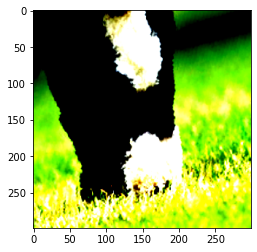

In [ ]:
img, label = train_ds[5]
show_sample(img, label, train_ds)
print(img.size())

##Helper Functions
Now, we will create helper funtions to train our model.
<img src="https://paperswithcode.com/media/methods/inceptionv3onc--oview_vjAbOfw.png">

In [9]:
import numpy as np
from timeit import default_timer as timer
import torch
import pandas as pd

def train(model,
          criterion,
          optimizer,
          scheduler,          
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
  
  # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    

     # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    
    overall_start = timer()
    
    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        scheduler.step(valid_loss)
        model.train()
        start = timer()
        
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            # mode we calculate the loss by summing the final output and the auxiliary output
            # but in testing we only consider the final output.
            output, aux_output = model(data)

            # Loss and backpropagation of gradients
            loss1 = criterion(output, target)
            loss2 = criterion(aux_output, target)
            loss = loss1 + 0.4*loss2
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        
                        return model

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    return model


Let's define our loss criterion, optimizer and scheduler to pass into the function we made above.
We use [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). It provides several methods to adjust the learning rate based on the number of epochs. Our function parameter scheduler is an object from it. 
Here, we have used `ReduceLROnPlateau` as the name suggests it reduces the Learning Rate when the quantity given as parameter to the function stops updating for a given number of epochs.

The syntax to be followed is essential here:
```
scheduler = ...
    for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()


In [10]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

Now, let's run the model.

In [11]:
model = train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_dl,
    val_dl,
    save_file_name="best.pth",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.5621 	Validation Loss: 0.2999
		Training Accuracy: 84.57%	 Validation Accuracy: 93.33%

Epoch: 1 	Training Loss: 0.4184 	Validation Loss: 0.2236
		Training Accuracy: 87.33%	 Validation Accuracy: 93.33%

Epoch: 2 	Training Loss: 0.3425 	Validation Loss: 0.1445
		Training Accuracy: 89.81%	 Validation Accuracy: 100.00%

Epoch: 3 	Training Loss: 0.3031 	Validation Loss: 0.1356
		Training Accuracy: 92.56%	 Validation Accuracy: 96.67%

Epoch: 4 	Training Loss: 0.3003 	Validation Loss: 0.1405
		Training Accuracy: 91.18%	 Validation Accuracy: 100.00%

Epoch: 5 	Training Loss: 0.3077 	Validation Loss: 0.1198
		Training Accuracy: 90.91%	 Validation Accuracy: 96.67%

Epoch: 6 	Training Loss: 0.3027 	Validation Loss: 0.1173
		Training Accuracy: 90.63%	 Validation Accuracy: 96.67%

Epoch: 7 	Training Loss: 0.2598 	Validation Loss: 0.1304
		Training Accuracy: 92.84%	 Validation Accuracy: 96.67%

Epoch: 8 	Training Loss: 0.2954 	Validation 

## Examining the Predictions
Now that our model has reached a high accuracy let's try it out on some test data it has never seen before. We will make a function to provide us with readable predictions on the test data we input.

In [12]:
from PIL import Image

def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((363, 363))

    # Center crop
    width = 363
    height = 363
    new_width = 299
    new_height = 299

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 363

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [13]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [16]:
x = process_image('/content/download.jpg')
x.shape

torch.Size([3, 299, 299])

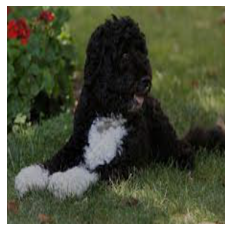

In [17]:
ax, image = imshow_tensor(x)

In [18]:
def predict(image_path,model):
  img_tensor = process_image(image_path)
  ax , image = imshow_tensor(img_tensor)
  img_tensor = img_tensor.view(1, 3, 299, 299).cuda()
  # Set to evaluation
  with torch.no_grad():
      model.eval()
      # Model outputs log probabilities
      out = model(img_tensor)
  
  prob, preds  = torch.max(out, dim=1)
  result = train_ds.classes[preds[0].item()]
  if (result == 'Bo'):
    print("It's Bo! Let him in!")
  else:
    print("That's not Bo! Stay out!")


It's Bo! Let him in!


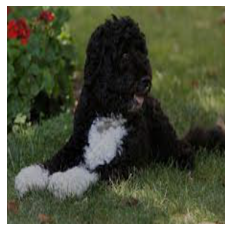

In [19]:
predict("/content/download.jpg",model)

## Fine-Tuning the Model

Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called [fine-tuning](https://developers.google.com/machine-learning/glossary#f). To do this we unfreeze the entire model, and train it again with a very small [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate). This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.  

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of [backpropagation](https://developers.google.com/machine-learning/glossary#backpropagation), large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [20]:
# Unfreeze the base model
# Freeze model weights
for param in model.parameters():
    param.requires_grad = True
#print(model)

In [21]:
summary(model, input_size=(3, 299, 299), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 149, 149]             864
       BatchNorm2d-2          [8, 32, 149, 149]              64
       BasicConv2d-3          [8, 32, 149, 149]               0
            Conv2d-4          [8, 32, 147, 147]           9,216
       BatchNorm2d-5          [8, 32, 147, 147]              64
       BasicConv2d-6          [8, 32, 147, 147]               0
            Conv2d-7          [8, 64, 147, 147]          18,432
       BatchNorm2d-8          [8, 64, 147, 147]             128
       BasicConv2d-9          [8, 64, 147, 147]               0
        MaxPool2d-10            [8, 64, 73, 73]               0
           Conv2d-11            [8, 80, 73, 73]           5,120
      BatchNorm2d-12            [8, 80, 73, 73]             160
      BasicConv2d-13            [8, 80, 73, 73]               0
           Conv2d-14           [8, 192,

In [22]:
model = train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_dl,
    val_dl,
    save_file_name="best.pth",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1)

Model has been trained for: 12 epochs.


Epoch: 0 	Training Loss: 0.2879 	Validation Loss: 0.1244
		Training Accuracy: 92.56%	 Validation Accuracy: 96.67%

Epoch: 1 	Training Loss: 0.2552 	Validation Loss: 0.1290
		Training Accuracy: 93.39%	 Validation Accuracy: 96.67%

Epoch: 2 	Training Loss: 0.2776 	Validation Loss: 0.1276
		Training Accuracy: 90.63%	 Validation Accuracy: 96.67%

Epoch: 3 	Training Loss: 0.2965 	Validation Loss: 0.1333
		Training Accuracy: 91.46%	 Validation Accuracy: 96.67%

Epoch: 4 	Training Loss: 0.2692 	Validation Loss: 0.1165
		Training Accuracy: 92.56%	 Validation Accuracy: 100.00%

Epoch: 5 	Training Loss: 0.2766 	Validation Loss: 0.1380
		Training Accuracy: 92.01%	 Validation Accuracy: 96.67%

Epoch: 6 	Training Loss: 0.2639 	Validation Loss: 0.1254
		Training Accuracy: 93.66%	 Validation Accuracy: 100.00%

Epoch: 7 	Training Loss: 0.2437 	Validation Loss: 0.1322
		Training Accuracy: 93.94%	 Validation Accuracy: 96.67%

Epoch: 8 	Training Loss: 0.2622 	Vali

Try this out on a couple images yourself and implement the `predict` function we made above to see the results to see the predictions. Since it is hard to uniquely identify a particular dog from image you might get positive results for any differnet of the same species. But that means our model can eefectively identify a particular species now!

That's not Bo! Stay out!


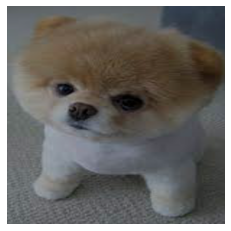

In [23]:
predict("/content/cute.jpg",model)